In [42]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm
import scipy
%matplotlib inline

In [87]:
def d(u, v):
    return np.linalg.norm(u - v, axis=-1)

In [109]:
def triangle_algorithm(S, p, eps = 1e-3, seed = 0):
    S_dist = scipy.spatial.distance_matrix(S, S)
    R = S_dist.max()
    p_dist = d(S, p)
    z = S[np.argmin(p_dist)]
    idx = np.arange(len(S))
    state = np.random.RandomState(seed)
    while True:
        if d(z, p) <= eps * R:
            return (True, z)
        z_dist = d(S, z)
        state.shuffle(idx)
        for i in idx:
            v = S[i]
            if d(z, v) >= p_dist[i]:
                x = v - z
                a = np.dot(p - z, x) / np.dot(x, x)
                z = (1 - a) * z + a * v
                break
        else:
            return (False, z)
        
def triangle_hull(S, eps = 1e-3, seed = 0):
    out = np.zeros(len(S), bool)
    for i in range(len(S)):
        v = S[i]
        S_v = np.concatenate([S[:i], S[i + 1:]])
        out[i] = not triangle_algorithm(S_v, v, eps=eps, seed=seed)[0]
    return out

In [152]:
def farthest(p, S):
    dist = d(S, p)
    return (dist == dist.max()).nonzero()[0]

def avta_hull(S, gamma = 1e-3, eps = 1e-3, seed = 0):
    n = len(S)
    state = np.random.RandomState(seed)
    points = S
    
    to_arr = lambda idx: points[list(idx)]
    
    def farthest(p, S):
        distances = d(to_arr(S), points[p])
        max_dist = distances.max()
        return set(i for i, dist in zip(S, distances) if dist == max_dist)
    
    S = set(range(n))
    v = state.randint(n)
    Sh = farthest(v, S)
    S0 = S - Sh
    
    v_new = None
    while True:
        if v_new is None:
            v = state.choice(list(S0))
        v_new = None
        pv = points[v]
        t, z = triangle_algorithm(to_arr(Sh), pv, eps=gamma / 2, seed=seed)
        if t:
            S0.remove(v)
            if not S0:
                out = np.zeros(n, bool)
                out[list(Sh)] = True
                return out
        else:
            c = pv - z
            obj = np.dot(to_arr(S0), c)
            obj_max = obj.max()
            S_new = {x for (x, o) in zip(S0, obj) if o == obj_max}
            v_new = state.choice(list(S_new))
            v_new = farthest(v_new, S_new)
            Sh.update(v_new)
            if v_new == v:
                v_new = None

In [175]:
def generate_points(n, seed = 0):
    return np.dot(np.random.RandomState(seed).uniform(size=(n, 2)), [[2, 1], [1, 2]])

def plot_hull(solver, n):
    print('-' * 80)
    print(f'Solver: {solver}')
    print(f'Points: {n:,d}')
    S = generate_points(n)
    func = avta_hull if solver.lower() == 'avta' else triangle_hull
    hull = %time func(S)
    plt.figure(figsize=(5, 5))
    plt.scatter(*S.T, s=20)
    plt.scatter(*S[hull].T, alpha=0.4, c='r', s=150)
    plt.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
Solver: Triangle
Points: 20
CPU times: user 163 ms, sys: 3.24 ms, total: 166 ms
Wall time: 168 ms


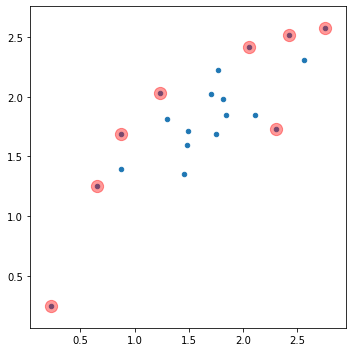

--------------------------------------------------------------------------------
Solver: AVTA
Points: 20
CPU times: user 74.8 ms, sys: 1.44 ms, total: 76.2 ms
Wall time: 76.8 ms


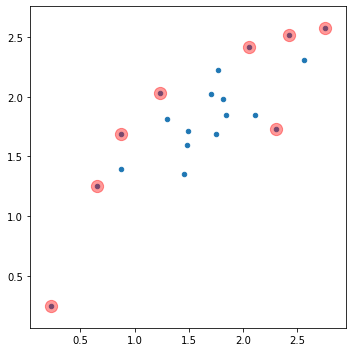

--------------------------------------------------------------------------------
Solver: Triangle
Points: 100
CPU times: user 5.93 s, sys: 86.9 ms, total: 6.01 s
Wall time: 6.09 s


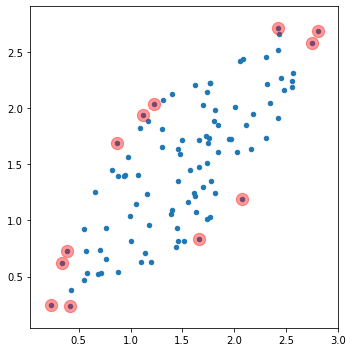

--------------------------------------------------------------------------------
Solver: AVTA
Points: 100
CPU times: user 2.31 s, sys: 35.6 ms, total: 2.35 s
Wall time: 2.38 s


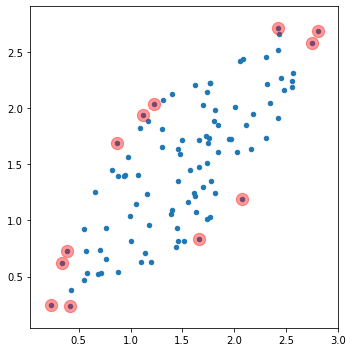

--------------------------------------------------------------------------------
Solver: Triangle
Points: 500
CPU times: user 2min 25s, sys: 2.28 s, total: 2min 27s
Wall time: 2min 29s


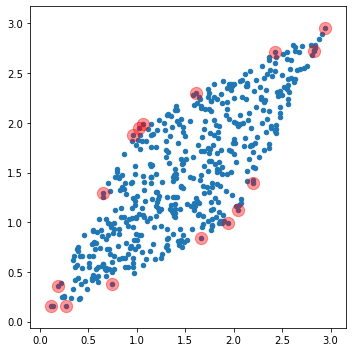

--------------------------------------------------------------------------------
Solver: AVTA
Points: 500
CPU times: user 11.6 s, sys: 147 ms, total: 11.7 s
Wall time: 11.9 s


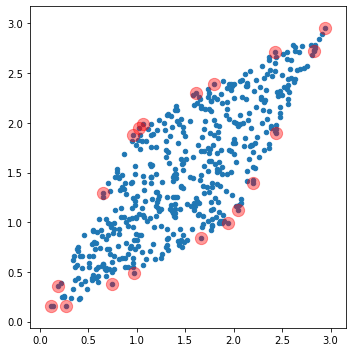

In [176]:
for n in (20, 100, 500):
    plot_hull('Triangle', n)
    plot_hull('AVTA', n)